In [26]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from datasim.ecg.ecg_simulate import *
from datasim.scg.scg_simulate import *
import pywt
from utils import *

In [27]:
scg_l = []
for i in range(1):
    scg = scg_simulate(duration=1000, heart_rate=70)
    scg_l.append(scg.flatten())

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
wavelet = pywt.Wavelet('sym4')
phi, psi, x = wavelet.wavefun(level=10)

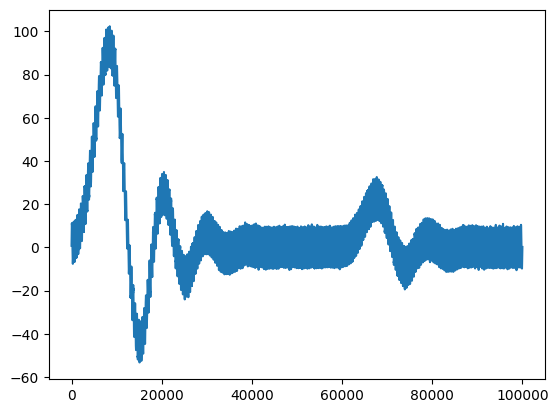

In [ ]:
plt.plot(scg)

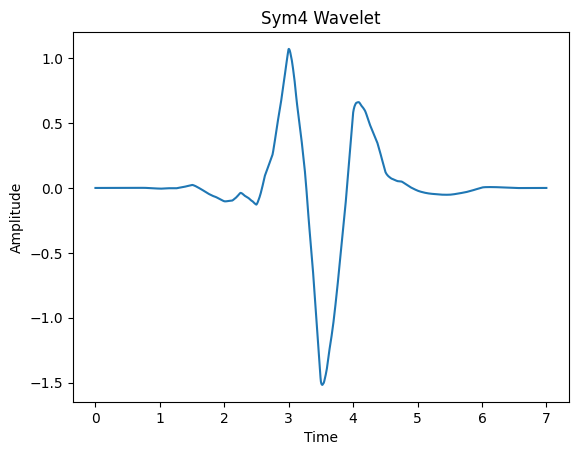

In [ ]:
plt.plot(x, psi)
plt.title('Sym4 Wavelet')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
influx = {'ip':'http://172.22.112.251', 'db':'shake',
                  'user':'algtest', 'passw':'sensorweb711', 
                  'ssl':False}

In [ ]:
unit = '11:01:11:01:11:01'
table_name = 'Z'

In [29]:
scg = np.random.randint(low=0, high=101, size=1000)

In [32]:
scg = scg.tolist()

In [34]:
scg[:10]

[34, 37, 12, 6, 71, 45, 78, 35, 9, 14]

In [35]:
write_influx(influx= influx, unit=unit,table_name=table_name, data_name='value', data=scg, start_timestamp=1736862357, fs = 1/100)

Done


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  % Total    % Received % Xferd  Average Speed   Time   

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5791    0     0  100  5791      0   324k --:--:-- --:--:-- --:--:--  332k
7 0:12-- 9-3 0-40 0 03        k     250 250 720-8k67-89   9--5 --8 ::0 0--  --0    
:5k   - 
   -  2 :  -30 0-0 1    k -  1 - -0 : 0 -  -0 :05  --7  :-911:4-0-0 -00-      - 5-5  :77- -9 -50: -8 :8- -  -  - :  2- - -4- 6 :  0k-   3  -1 02-:4 3--7k :k--
   -- -2:2:0-3--2-5 :kk-- --
-: -----:::----- -:-:----: ---- -::------ :: --2-5- 7: k2-
4-6k 
--:--:--  209k
100  5792    0     0  100  5792      0   255k --:--:-- --:--:-- --:--:--  257k
100  5789    0     0  100  5789      0   169k --:--:-- --:--:-- --:--:--  171k


In [37]:
def sine_gen (amp, samples):
    frequency = 1       # Frequency in Hz
    amplitude = amp       # Amplitude of the sine wave
    sampling_rate = samples # Sampling rate in Hz
    duration = 1        # Duration in seconds
    # Generate the time axis
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

    # Generate the sine wave
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * t)       
    return sine_wave

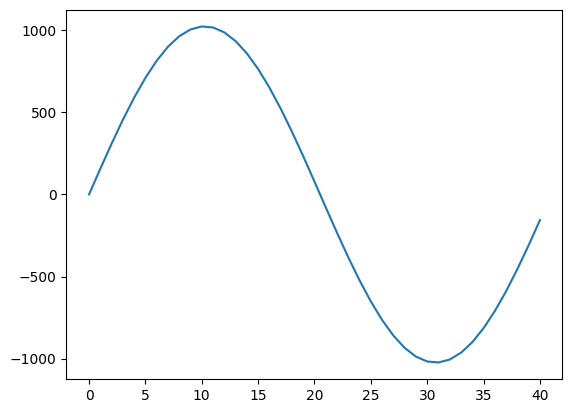

In [38]:
a = sine_gen(1024,41)
plt.plot(a)